# Elastic Net - Predicción de Violencia Atípica en Colombia
## Versión SIN Gap Temporal - PARAMETRIZABLE

Este notebook implementa un modelo de Elastic Net con:
- **Configuración parametrizable** (sin hardcoding de años)
- Splits temporales automáticos basados en proporciones
- Sin leakage temporal
- Evaluación honesta en conjunto de prueba retenido
- Optimización por AUPRC (métrica principal del proyecto)

## 🔧 CONFIGURACIÓN GLOBAL DEL PROYECTO

**Ajusta estos parámetros según tus necesidades:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    average_precision_score, roc_auc_score, balanced_accuracy_score,
    f1_score, cohen_kappa_score, confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, precision_score, recall_score
)
from sklearn.impute import SimpleImputer
import warnings
import os
from datetime import datetime
from pathlib import Path  # For cross-platform file path handling
import yaml  # To read YAML configuration files

# Load directory paths from configuration file
with open('paths.yml', 'r') as file:
    paths = yaml.safe_load(file)  # Read and parse YAML file

# Create Path objects for each directory
raw = Path(paths['data']['raw'])  # Directory with raw data
temp = Path(paths['data']['temp'])  # Directory with temporary processed data
processed = Path(paths['data']['processed'])  # Directory with final processed data
model = Path(paths['outputs']['model'])

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
# ============================================================================
# CONFIGURACIÓN PARAMETRIZABLE - MODIFICAR AQUÍ
# ============================================================================

# RUTAS DE ARCHIVOS
DATA_PATH = processed/'db_no_jep.parquet'
RESULTS_DIR = "/Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous"

# NOMBRE DE COLUMNAS CLAVE
TARGET_COL = 'atypical_violence'
TIME_COL = 'quarter'  # Formato: 'YYYYQN' (ej: '2006Q1')
MUNICIPALITY_COL = 'mun_code'

# COLUMNAS A EXCLUIR DEL MODELO
COLS_TO_EXCLUDE = [
    # Variable dependiente
    'atypical_violence',
    # Identificadores
    'mun_code', 'quarter',
    # Variables de violencia contemporánea (target leakage)
    'iacv', 'iacv_t', 'qty_iacv', 'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05',
    # Población absoluta
    'population',
    '_merge'  # ← AGREGAR ESTA LÍNEA,
    
]

# SPLITS TEMPORALES - Opción 1: Por PROPORCIONES
TRAIN_PROP = 0.70  # 70% para entrenamiento
VAL_PROP = 0.15    # 15% para validación
TEST_PROP = 0.15   # 15% para test
# Nota: TRAIN_PROP + VAL_PROP + TEST_PROP debe sumar 1.0

# SPLITS TEMPORALES - Opción 2: Por AÑOS ESPECÍFICOS (comentar si usas proporciones)
# Descomentar y ajustar estas líneas si prefieres especificar años manualmente:
# TRAIN_END_YEAR = 2020
# TRAIN_END_QUARTER = 4
# VAL_END_YEAR = 2022
# VAL_END_QUARTER = 4
# USE_YEAR_SPLITS = True  # Cambiar a True para usar años en lugar de proporciones
USE_YEAR_SPLITS = False  # Por defecto usa proporciones

# HIPERPARÁMETROS DEL MODELO
ELASTIC_NET_PARAMS = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# VALIDACIÓN CRUZADA
N_CV_SPLITS = 5  # Número de folds en TimeSeriesSplit

# OPTIMIZACIÓN DE THRESHOLD
THRESHOLD_RANGE = (0.1, 0.9)  # Rango de thresholds a evaluar
THRESHOLD_STEP = 0.05          # Paso entre thresholds

# IMPUTACIÓN
NUMERIC_IMPUTATION = 'median'  # 'mean', 'median', 'most_frequent'
CATEGORICAL_IMPUTATION = 'most_frequent'  # 'most_frequent', 'constant'

# RANDOM STATE (para reproducibilidad)
RANDOM_STATE = 42

# NOMBRE DEL EXPERIMENTO (para archivos de salida)
EXPERIMENT_NAME = 'elasticnet_sin_gap'

print("✓ Configuración cargada exitosamente")
print(f"\nExperimento: {EXPERIMENT_NAME}")
print(f"Target: {TARGET_COL}")
print(f"Columna temporal: {TIME_COL}")
print(f"Variables a excluir: {len(COLS_TO_EXCLUDE)}")
print(f"Splits: Train {TRAIN_PROP:.0%} | Val {VAL_PROP:.0%} | Test {TEST_PROP:.0%}")

✓ Configuración cargada exitosamente

Experimento: elasticnet_sin_gap
Target: atypical_violence
Columna temporal: quarter
Variables a excluir: 13
Splits: Train 70% | Val 15% | Test 15%


## 1. Carga y Preparación de Datos

In [3]:
# Cargar datos
print(f"Cargando datos desde: {DATA_PATH}")
df = pd.read_parquet(DATA_PATH)

print(f"\n✓ Datos cargados exitosamente")
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"\nPrimeras filas:")
df.head()

Cargando datos desde: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/data/processed/db_no_jep.parquet

✓ Datos cargados exitosamente
Dimensiones: 76,184 filas × 67 columnas

Primeras filas:


,mun_code,quarter,iacv,iacv_t,atypical_violence,iacv_r1,iacv_r2,iacv_r3,iacv_r4,qty_iacv,...,ipm_hacinam_p_2005,ipm_hacinam_p_2018,indrural,areaoficialkm2,altura,discapital,dismdo,disbogota,distancia_mercado,_merge
0,05001,2006Q1,1.53,1.809,0,1.63,1.88,1.49,1.55,31.59,...,11.78,5.4,0.017527,5287.702842,1475.0,0.0,0.0,264.33902,0.0,both
1,05001,2006Q2,1.44,1.808,0,1.53,1.63,1.88,1.49,29.85,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both
2,05001,2006Q3,1.58,1.810,0,1.44,1.53,1.63,1.88,32.64,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both
3,05001,2006Q4,1.44,1.626,0,1.58,1.44,1.53,1.63,29.91,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both
4,05001,2007Q1,1.31,1.567,0,1.44,1.58,1.44,1.53,27.31,...,11.78,5.4,0.016824,5359.677003,1475.0,0.0,0.0,264.33902,0.0,both


In [4]:
# Verificar columnas requeridas
required_cols = [TARGET_COL, TIME_COL, MUNICIPALITY_COL]
missing_cols = [col for col in required_cols if col not in df.columns]

if missing_cols:
    raise ValueError(f"❌ Columnas requeridas faltantes: {missing_cols}")

print("✓ Todas las columnas requeridas están presentes")
print(f"\nColumnas en el dataset ({len(df.columns)} total):")
print(df.columns.tolist()[:20], "...")

✓ Todas las columnas requeridas están presentes

Columnas en el dataset (67 total):
['mun_code', 'quarter', 'iacv', 'iacv_t', 'atypical_violence', 'iacv_r1', 'iacv_r2', 'iacv_r3', 'iacv_r4', 'qty_iacv', 'qty_01', 'qty_02', 'qty_03', 'qty_04', 'qty_05', 'population', 'women_share', 'coca', 'amapola', 'y_corr'] ...


In [5]:
# Extraer año y trimestre desde la columna TIME_COL
# Formato esperado: 'YYYYQN' (ej: '2006Q1', '2020Q4')
df['año'] = df[TIME_COL].astype(str).str[:4].astype(int)
df['trimestre'] = df[TIME_COL].astype(str).str[-1].astype(int)
df['periodo_num'] = df['año'] * 10 + df['trimestre']

# Ordenar por tiempo y municipio
df = df.sort_values(['periodo_num', MUNICIPALITY_COL]).reset_index(drop=True)

print("✓ Variables temporales extraídas y datos ordenados")
print(f"\nRango temporal completo:")
print(f"  Inicio: {df['año'].min()}-Q{df['trimestre'].min()} ({df[TIME_COL].min()})")
print(f"  Fin:    {df['año'].max()}-Q{df['trimestre'].max()} ({df[TIME_COL].max()})")
print(f"  Total periodos únicos: {df[TIME_COL].nunique()}")
print(f"  Total municipios: {df[MUNICIPALITY_COL].nunique()}")
print(f"  Observaciones totales: {len(df):,}")

✓ Variables temporales extraídas y datos ordenados

Rango temporal completo:
  Inicio: 2006-Q1 (2006Q1)
  Fin:    2022-Q4 (2022Q4)
  Total periodos únicos: 68
  Total municipios: 1121
  Observaciones totales: 76,184


In [ ]:
df

## 2. Análisis de Variable Dependiente

In [6]:
# Verificar variable dependiente
print(f"Distribución de '{TARGET_COL}':")
print(df[TARGET_COL].value_counts().sort_index())

prevalence = df[TARGET_COL].mean()
imbalance_ratio = (1 - prevalence) / prevalence if prevalence > 0 else np.inf

print(f"\nPrevalencia (clase positiva): {prevalence:.2%}")
print(f"Desbalance de clases: {imbalance_ratio:.2f}:1")

if prevalence < 0.05:
    print("\n⚠️  Advertencia: Desbalance EXTREMO (<5%). Considerar SMOTE u otras técnicas.")
elif prevalence < 0.15:
    print("\n⚠️  Desbalance significativo (<15%). class_weight='balanced' es crítico.")

Distribución de 'atypical_violence':
atypical_violence
0    61914
1    14270
Name: count, dtype: int64

Prevalencia (clase positiva): 18.73%
Desbalance de clases: 4.34:1


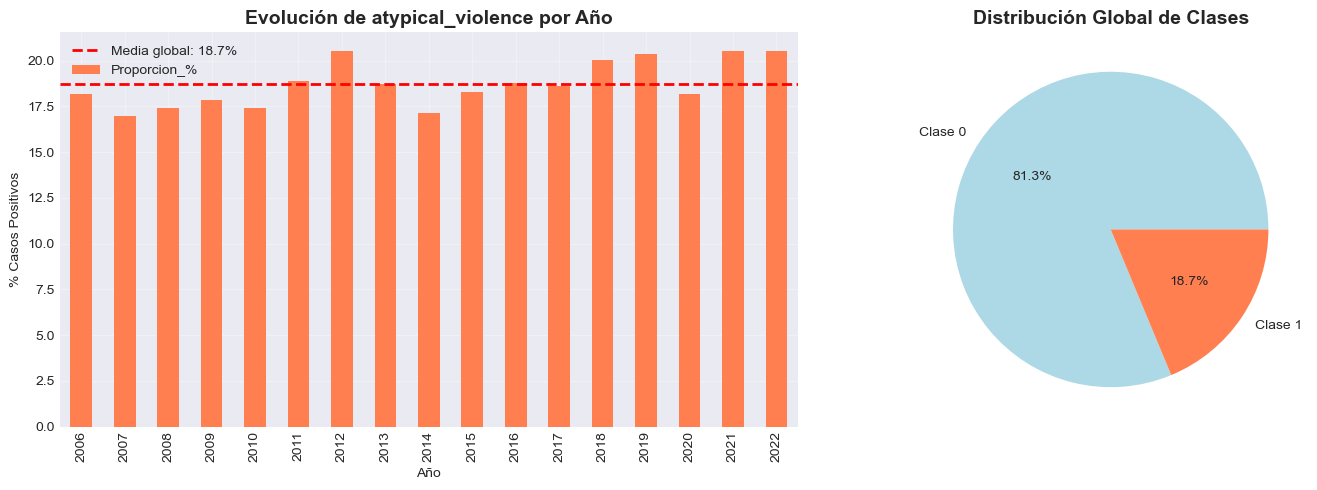


Distribución por año:
      Casos_Positivos  Total_Obs  Proporcion  Proporcion_%
año                                                       
2006              813       4468    0.181961     18.196061
2007              758       4468    0.169651     16.965085
2008              778       4472    0.173971     17.397138
2009              801       4484    0.178635     17.863515
2010              781       4484    0.174175     17.417484
2011              846       4484    0.188671     18.867083
2012              920       4484    0.205174     20.517395
2013              840       4484    0.187333     18.733274
2014              769       4484    0.171499     17.149866
2015              819       4484    0.182649     18.264942
2016              843       4484    0.188002     18.800178
2017              835       4484    0.186218     18.621766
2018              897       4484    0.200045     20.004460
2019              914       4484    0.203836     20.383586
2020              816       4484 

In [7]:
# Distribución temporal de la variable dependiente
temporal_dist = df.groupby('año')[TARGET_COL].agg(['sum', 'count', 'mean'])
temporal_dist.columns = ['Casos_Positivos', 'Total_Obs', 'Proporcion']
temporal_dist['Proporcion_%'] = temporal_dist['Proporcion'] * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Evolución temporal
temporal_dist['Proporcion_%'].plot(kind='bar', ax=ax1, color='coral')
ax1.axhline(prevalence * 100, color='red', linestyle='--', linewidth=2,
            label=f'Media global: {prevalence*100:.1f}%')
ax1.set_title(f'Evolución de {TARGET_COL} por Año', fontsize=14, fontweight='bold')
ax1.set_xlabel('Año')
ax1.set_ylabel('% Casos Positivos')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Distribución global
df[TARGET_COL].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                                    labels=['Clase 0', 'Clase 1'],
                                    colors=['lightblue', 'coral'])
ax2.set_title('Distribución Global de Clases', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\nDistribución por año:")
print(temporal_dist)

## 3. Splits Temporales Automáticos (SIN Gap)

El split se calcula automáticamente basado en las proporciones configuradas.

In [8]:
# Obtener periodos únicos ordenados
periodos_unicos = sorted(df[TIME_COL].unique())
n_periodos = len(periodos_unicos)

print(f"Total de periodos únicos: {n_periodos}")
print(f"Primer periodo: {periodos_unicos[0]}")
print(f"Último periodo: {periodos_unicos[-1]}")

Total de periodos únicos: 68
Primer periodo: 2006Q1
Último periodo: 2022Q4


In [9]:
# Calcular puntos de corte según proporciones
if USE_YEAR_SPLITS:
    # Opción manual: usar años específicos
    train_cutoff = f"{TRAIN_END_YEAR}Q{TRAIN_END_QUARTER}"
    val_cutoff = f"{VAL_END_YEAR}Q{VAL_END_QUARTER}"
    
    train_mask = df[TIME_COL] <= train_cutoff
    val_mask = (df[TIME_COL] > train_cutoff) & (df[TIME_COL] <= val_cutoff)
    test_mask = df[TIME_COL] > val_cutoff
    
    print(f"✓ Usando splits por años específicos:")
    print(f"  Train: hasta {train_cutoff}")
    print(f"  Val: {train_cutoff} < t <= {val_cutoff}")
    print(f"  Test: > {val_cutoff}")
else:
    # Opción automática: usar proporciones
    train_end_idx = int(n_periodos * TRAIN_PROP)
    val_end_idx = int(n_periodos * (TRAIN_PROP + VAL_PROP))
    
    train_periods = periodos_unicos[:train_end_idx]
    val_periods = periodos_unicos[train_end_idx:val_end_idx]
    test_periods = periodos_unicos[val_end_idx:]
    
    train_mask = df[TIME_COL].isin(train_periods)
    val_mask = df[TIME_COL].isin(val_periods)
    test_mask = df[TIME_COL].isin(test_periods)
    
    print(f"✓ Splits calculados automáticamente por proporciones:")
    print(f"  Train: {len(train_periods)} periodos ({train_periods[0]} a {train_periods[-1]})")
    print(f"  Val:   {len(val_periods)} periodos ({val_periods[0]} a {val_periods[-1]})")
    print(f"  Test:  {len(test_periods)} periodos ({test_periods[0]} a {test_periods[-1]})")

# Verificar continuidad
print(f"\n{'='*70}")
print("VERIFICACIÓN DE SPLITS")
print(f"{'='*70}")
print(f"Train: {train_mask.sum():,} obs ({train_mask.sum()/len(df)*100:.1f}%)")
print(f"Val:   {val_mask.sum():,} obs ({val_mask.sum()/len(df)*100:.1f}%)")
print(f"Test:  {test_mask.sum():,} obs ({test_mask.sum()/len(df)*100:.1f}%)")
print(f"Total: {len(df):,} obs")

# Validar que no hay overlap
assert (train_mask & val_mask).sum() == 0, "❌ Overlap entre Train y Val"
assert (train_mask & test_mask).sum() == 0, "❌ Overlap entre Train y Test"
assert (val_mask & test_mask).sum() == 0, "❌ Overlap entre Val y Test"
assert train_mask.sum() + val_mask.sum() + test_mask.sum() == len(df), "❌ Observaciones faltantes"

print("\n✓ Splits validados: sin overlap, sin observaciones faltantes")

✓ Splits calculados automáticamente por proporciones:
  Train: 47 periodos (2006Q1 a 2017Q3)
  Val:   10 periodos (2017Q4 a 2020Q1)
  Test:  11 periodos (2020Q2 a 2022Q4)

VERIFICACIÓN DE SPLITS
Train: 52,643 obs (69.1%)
Val:   11,210 obs (14.7%)
Test:  12,331 obs (16.2%)
Total: 76,184 obs

✓ Splits validados: sin overlap, sin observaciones faltantes


## 4. Separación de Features y Target

In [10]:
# Agregar variables derivadas a la lista de exclusión
derived_cols = ['año', 'trimestre', 'periodo_num']
all_cols_to_exclude = list(set(COLS_TO_EXCLUDE + derived_cols))

# Verificar columnas a excluir
cols_excluir_existentes = [col for col in all_cols_to_exclude if col in df.columns]
cols_excluir_faltantes = [col for col in all_cols_to_exclude if col not in df.columns]

if cols_excluir_faltantes:
    print(f"⚠️  Columnas en COLS_TO_EXCLUDE que NO existen: {cols_excluir_faltantes}")

# Features finales
feature_cols = [col for col in df.columns if col not in cols_excluir_existentes]

print(f"{'='*70}")
print("FEATURES DEL MODELO")
print(f"{'='*70}")
print(f"\nColumnas excluidas: {len(cols_excluir_existentes)}")
for col in sorted(cols_excluir_existentes):
    print(f"  - {col}")

print(f"\nFeatures disponibles: {len(feature_cols)}")
print(f"\nPrimeras 30 features:")
for i, col in enumerate(feature_cols[:30], 1):
    print(f"  {i:2d}. {col}")
if len(feature_cols) > 30:
    print(f"\n  ... y {len(feature_cols)-30} más")

# Separar X e y
X = df[feature_cols].copy()
y = df[TARGET_COL].copy()

print(f"\n{'='*70}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Prevalencia en y: {y.mean():.2%}")

FEATURES DEL MODELO

Columnas excluidas: 16
  - _merge
  - atypical_violence
  - año
  - iacv
  - iacv_t
  - mun_code
  - periodo_num
  - population
  - qty_01
  - qty_02
  - qty_03
  - qty_04
  - qty_05
  - qty_iacv
  - quarter
  - trimestre

Features disponibles: 54

Primeras 30 features:
   1. iacv_r1
   2. iacv_r2
   3. iacv_r3
   4. iacv_r4
   5. women_share
   6. coca
   7. amapola
   8. y_corr
   9. y_corr_tribut_IyC
  10. DF_ing_func
  11. DF_deuda
  12. DF_desemp_fisc
  13. s11_total
  14. docen_total
  15. alumn_total
  16. nbi_2005
  17. nbi_2018
  18. IPM_2005
  19. IPM_2018
  20. ipm_ledu_p_2005
  21. ipm_ledu_p_2018
  22. ipm_analf_p_2005
  23. ipm_analf_p_2018
  24. ipm_asisescu_p_2005
  25. ipm_asisescu_p_2018
  26. ipm_rezagoescu_p_2005
  27. ipm_rezagoescu_p_2018
  28. ipm_serv_pinf_p_2005
  29. ipm_serv_pinf_p_2018
  30. ipm_ti_p_2005

  ... y 24 más

X shape: (76184, 54)
y shape: (76184,)
Prevalencia en y: 18.73%


In [11]:
# Aplicar máscaras para crear splits
X_train, y_train = X[train_mask].copy(), y[train_mask].copy()
X_val, y_val = X[val_mask].copy(), y[val_mask].copy()
X_test, y_test = X[test_mask].copy(), y[test_mask].copy()

print("Dimensiones de los splits:")
print(f"  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape}   | y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}  | y_test:  {y_test.shape}")

Dimensiones de los splits:
  X_train: (52643, 54) | y_train: (52643,)
  X_val:   (11210, 54)   | y_val:   (11210,)
  X_test:  (12331, 54)  | y_test:  (12331,)


In [12]:
# Verificar distribución de clases en cada split
print(f"\n{'='*70}")
print("DISTRIBUCIÓN DE CLASES POR SPLIT")
print(f"{'='*70}")

for split_name, y_split in [('Train', y_train), ('Validation', y_val), ('Test', y_test)]:
    prop = y_split.mean()
    n_pos = y_split.sum()
    n_neg = len(y_split) - n_pos
    ratio = n_neg / n_pos if n_pos > 0 else np.inf
    
    print(f"\n{split_name}:")
    print(f"  Clase 1 (positivo): {n_pos:,} ({prop:.2%})")
    print(f"  Clase 0 (negativo): {n_neg:,} ({1-prop:.2%})")
    print(f"  Desbalance: {ratio:.2f}:1")

# Advertencia si splits muy diferentes
props = [y_train.mean(), y_val.mean(), y_test.mean()]
if max(props) / min(props) > 1.5:
    print("\n⚠️  Advertencia: Distribuciones de clase muy diferentes entre splits")
    print("    Considerar estratificación o revisar splits temporales")


DISTRIBUCIÓN DE CLASES POR SPLIT

Train:
  Clase 1 (positivo): 9,613 (18.26%)
  Clase 0 (negativo): 43,030 (81.74%)
  Desbalance: 4.48:1

Validation:
  Clase 1 (positivo): 2,167 (19.33%)
  Clase 0 (negativo): 9,043 (80.67%)
  Desbalance: 4.17:1

Test:
  Clase 1 (positivo): 2,490 (20.19%)
  Clase 0 (negativo): 9,841 (79.81%)
  Desbalance: 3.95:1


## 5. Análisis y Manejo de Datos Faltantes

In [13]:
# Analizar missingness en train
missing_train = X_train.isnull().sum()
missing_pct = (missing_train / len(X_train) * 100).sort_values(ascending=False)
missing_cols = missing_pct[missing_pct > 0]

print(f"Variables con datos faltantes en Train: {len(missing_cols)} de {len(feature_cols)}")

if len(missing_cols) > 0:
    print(f"\nTop 20 variables con más missingness:")
    print(missing_cols.head(20))
    
    # Visualizar
    if len(missing_cols) > 0:
        top_missing = missing_cols.head(15)
        plt.figure(figsize=(10, 6))
        top_missing.plot(kind='barh', color='salmon')
        plt.xlabel('% Datos Faltantes')
        plt.title(f'Top 15 Variables con Missingness (Train Set)', fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
else:
    print("\n✓ No hay datos faltantes en el conjunto de entrenamiento")

Variables con datos faltantes en Train: 0 de 54

✓ No hay datos faltantes en el conjunto de entrenamiento


In [14]:
# Imputación
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"Columnas numéricas: {len(numeric_cols)}")
print(f"Columnas categóricas: {len(categorical_cols)}")

# Imputer numérico - ajustado SOLO en train
if len(numeric_cols) > 0 and X_train[numeric_cols].isnull().sum().sum() > 0:
    num_imputer = SimpleImputer(strategy=NUMERIC_IMPUTATION)
    X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
    X_val[numeric_cols] = num_imputer.transform(X_val[numeric_cols])
    X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
    print(f"\n✓ Imputación numérica completada (estrategia: {NUMERIC_IMPUTATION})")

# Imputer categórico - ajustado SOLO en train
if len(categorical_cols) > 0 and X_train[categorical_cols].isnull().sum().sum() > 0:
    cat_imputer = SimpleImputer(strategy=CATEGORICAL_IMPUTATION)
    X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
    X_val[categorical_cols] = cat_imputer.transform(X_val[categorical_cols])
    X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])
    print(f"✓ Imputación categórica completada (estrategia: {CATEGORICAL_IMPUTATION})")

# Verificar
print(f"\nNaNs restantes:")
print(f"  Train: {X_train.isnull().sum().sum()}")
print(f"  Val:   {X_val.isnull().sum().sum()}")
print(f"  Test:  {X_test.isnull().sum().sum()}")

Columnas numéricas: 54
Columnas categóricas: 0

NaNs restantes:
  Train: 0
  Val:   0
  Test:  0


## 6. Estandarización (Sin Leakage)

In [15]:
# Estandarizar SOLO con estadísticas de train
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Estandarización completada SIN leakage")
print(f"\nEstadísticas aprendidas del train (primeras 5 features):")
print(f"  Media: {scaler.mean_[:5]}")
print(f"  Std:   {scaler.scale_[:5]}")

# Convertir a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

# Verificar estandarización
print(f"\nVerificación (Train):")
print(f"  Media ~0: {X_train_scaled.mean().abs().max():.6f}")
print(f"  Std ~1:   {(X_train_scaled.std() - 1).abs().max():.6f}")

✓ Estandarización completada SIN leakage

Estadísticas aprendidas del train (primeras 5 features):
  Media: [1.42784055 1.44171799 1.45351899 1.46996771 0.49143312]
  Std:   [2.36865368 2.44235728 2.4637206  2.50490341 0.01921057]

Verificación (Train):
  Media ~0: 0.000000
  Std ~1:   0.000009


## 7. Optimización de Hiperparámetros

In [16]:
# Combinar train y val para GridSearch
X_train_val = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

print(f"Dataset para GridSearch:")
print(f"  Shape: {X_train_val.shape}")
print(f"  Prevalencia: {y_train_val.mean():.2%}")

Dataset para GridSearch:
  Shape: (63853, 54)
  Prevalencia: 18.45%


In [17]:
# Modelo base
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=2000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Configuración del GridSearch:")
print(f"  Parámetros: {ELASTIC_NET_PARAMS}")
print(f"  CV folds: {N_CV_SPLITS}")
print(f"  Métrica: average_precision (AUPRC)")
print(f"  Total combinaciones: {len(ELASTIC_NET_PARAMS['C']) * len(ELASTIC_NET_PARAMS['l1_ratio'])}")

Configuración del GridSearch:
  Parámetros: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
  CV folds: 5
  Métrica: average_precision (AUPRC)
  Total combinaciones: 30


In [18]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=N_CV_SPLITS)

print(f"\nTimeSeriesSplit ({N_CV_SPLITS} folds):")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):
    print(f"  Fold {i}: Train={len(train_idx):,} | Val={len(val_idx):,}")


TimeSeriesSplit (5 folds):
  Fold 1: Train=10,643 | Val=10,642
  Fold 2: Train=21,285 | Val=10,642
  Fold 3: Train=31,927 | Val=10,642
  Fold 4: Train=42,569 | Val=10,642
  Fold 5: Train=53,211 | Val=10,642


In [19]:
# GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=ELASTIC_NET_PARAMS,
    cv=tscv,
    scoring='f1',#'average_precision',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("\n🚀 Iniciando GridSearchCV...")
print(f"Tiempo estimado: ~{len(ELASTIC_NET_PARAMS['C']) * len(ELASTIC_NET_PARAMS['l1_ratio']) * 2} minutos\n")

grid_search.fit(X_train_val, y_train_val)

print("\n✓ GridSearchCV completado")


🚀 Iniciando GridSearchCV...
Tiempo estimado: ~60 minutos

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ..............................C=0.001, l1_ratio=0.1; total time=   0.6s
[CV] END ..............................C=0.001, l1_ratio=0.5; total time=   0.3s
[CV] END ..............................C=0.001, l1_ratio=0.3; total time=   0.7s
[CV] END ..............................C=0.001, l1_ratio=0.1; total time=   1.3s
[CV] END ..............................C=0.001, l1_ratio=0.3; total time=   1.0s
[CV] END ..............................C=0.001, l1_ratio=0.3; total time=   1.3s
[CV] END ..............................C=0.001, l1_ratio=0.7; total time=   0.1s
[CV] END ..............................C=0.001, l1_ratio=0.1; total time=   1.9s
[CV] END ..............................C=0.001, l1_ratio=0.5; total time=   1.2s
[CV] END ..............................C=0.001, l1_ratio=0.5; total time=   1.3s
[CV] END ..............................C=0.001, l1_ratio=0.1; total t

In [20]:
# Resultados
print(f"\n{'='*70}")
print("RESULTADOS DE GRIDSEARCHCV")
print(f"{'='*70}")

print(f"\nMejores hiperparámetros:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMejor AUPRC (CV): {grid_search.best_score_:.4f}")

# Top 10 configs
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')
print("\nTop 10 configuraciones:")
print(cv_results[['param_C', 'param_l1_ratio', 'mean_test_score', 'std_test_score']].head(10))

best_model = grid_search.best_estimator_


RESULTADOS DE GRIDSEARCHCV

Mejores hiperparámetros:
  C: 0.01
  l1_ratio: 0.9

Mejor AUPRC (CV): 0.3543

Top 10 configuraciones:
    param_C  param_l1_ratio  mean_test_score  std_test_score
9     0.010             0.9         0.354260        0.008512
0     0.001             0.1         0.354224        0.008728
7     0.010             0.5         0.354052        0.007844
8     0.010             0.7         0.353787        0.007718
5     0.010             0.1         0.353578        0.008366
17    1.000             0.5         0.353559        0.010214
15    1.000             0.1         0.353551        0.010193
16    1.000             0.3         0.353542        0.010166
22   10.000             0.5         0.353507        0.010197
21   10.000             0.3         0.353498        0.010229


## 8. Optimización de Threshold

Threshold óptimo: 0.50
F1-Score en ese threshold: 0.3626


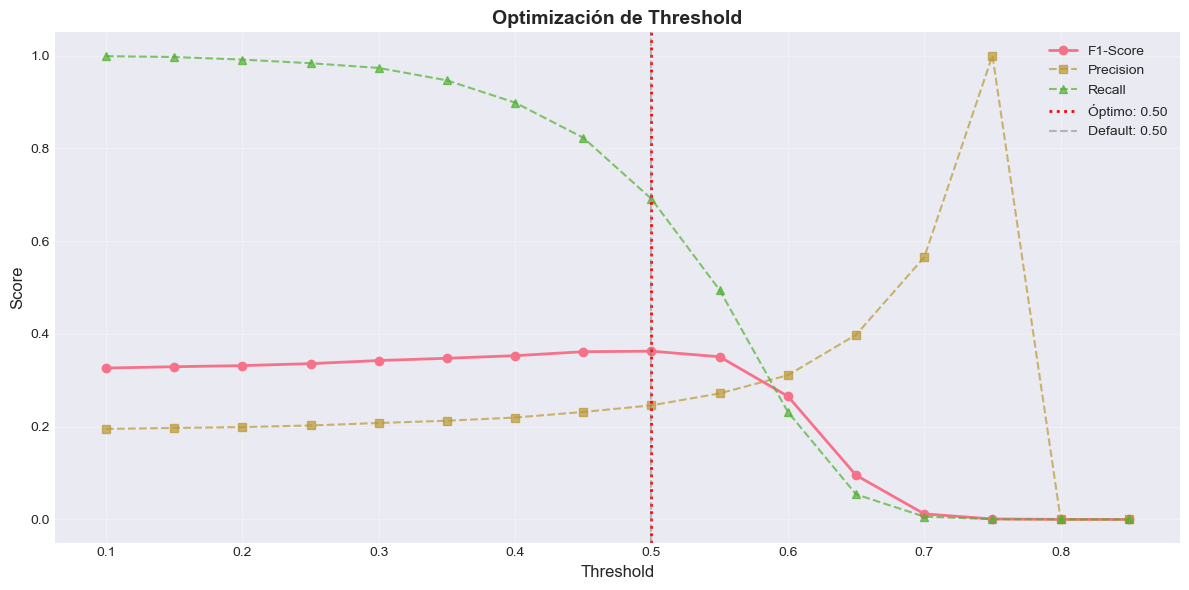

In [21]:
# Evaluar thresholds en validation
y_val_proba = best_model.predict_proba(X_val_scaled)[:, 1]

thresholds = np.arange(THRESHOLD_RANGE[0], THRESHOLD_RANGE[1], THRESHOLD_STEP)
f1_scores = []
precision_scores = []
recall_scores = []

for thresh in thresholds:
    y_pred = (y_val_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred, zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred, zero_division=0))

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

print(f"Threshold óptimo: {best_threshold:.2f}")
print(f"F1-Score en ese threshold: {f1_scores[best_threshold_idx]:.4f}")

# Visualizar
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(thresholds, f1_scores, 'o-', label='F1-Score', linewidth=2)
ax.plot(thresholds, precision_scores, 's--', label='Precision', alpha=0.7)
ax.plot(thresholds, recall_scores, '^--', label='Recall', alpha=0.7)
ax.axvline(best_threshold, color='red', linestyle=':', linewidth=2,
           label=f'Óptimo: {best_threshold:.2f}')
ax.axvline(0.5, color='gray', linestyle='--', alpha=0.5, label='Default: 0.50')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Optimización de Threshold', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Evaluación Final en Test Set

In [22]:
# Predicciones en test
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

# Métricas
metricas_test = {
    'AUPRC': average_precision_score(y_test, y_test_proba),
    'AUROC': roc_auc_score(y_test, y_test_proba),
    'Balanced_Accuracy': balanced_accuracy_score(y_test, y_test_pred),
    'F1_Score': f1_score(y_test, y_test_pred),
    'Cohen_Kappa': cohen_kappa_score(y_test, y_test_pred)
}

print(f"\n{'='*70}")
print("EVALUACIÓN FINAL EN TEST SET")
print(f"{'='*70}")
print(f"\nMétricas:")
for metric, value in metricas_test.items():
    print(f"  {metric:20s}: {value:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Clase 0', 'Clase 1'], digits=4))


EVALUACIÓN FINAL EN TEST SET

Métricas:
  AUPRC               : 0.2852
  AUROC               : 0.6324
  Balanced_Accuracy   : 0.5959
  F1_Score            : 0.3777
  Cohen_Kappa         : 0.1166

Classification Report:
              precision    recall  f1-score   support

     Clase 0     0.8670    0.4875    0.6240      9841
     Clase 1     0.2580    0.7044    0.3777      2490

    accuracy                         0.5313     12331
   macro avg     0.5625    0.5959    0.5009     12331
weighted avg     0.7440    0.5313    0.5743     12331



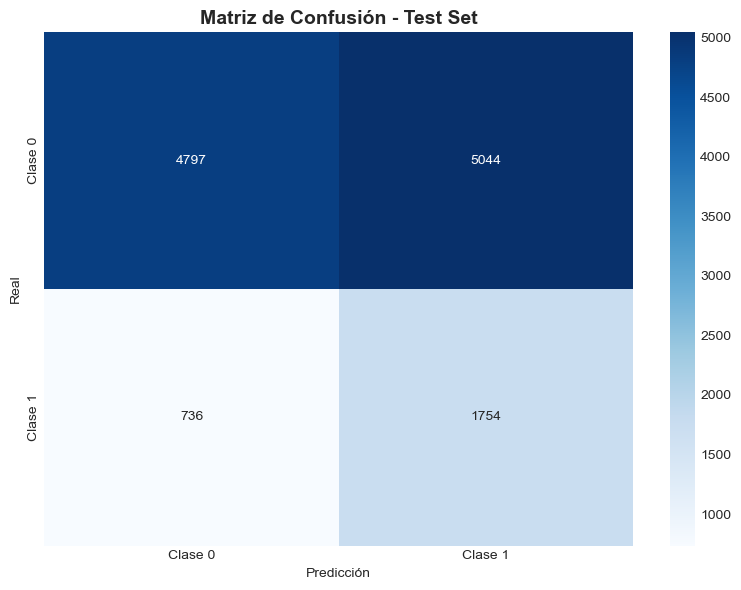


Desglose:
  TN: 4,797 | FP: 5,044
  FN: 736 | TP: 1,754

  Recall: 0.7044
  Precision: 0.2580


In [23]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de Confusión - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"\nDesglose:")
print(f"  TN: {tn:,} | FP: {fp:,}")
print(f"  FN: {fn:,} | TP: {tp:,}")
print(f"\n  Recall: {tp/(tp+fn):.4f}")
print(f"  Precision: {tp/(tp+fp):.4f}" if (tp+fp) > 0 else "  Precision: N/A")

## 10. Interpretabilidad

In [24]:
# Coeficientes
coeficientes = pd.DataFrame({
    'Feature': feature_cols,
    'Coeficiente': best_model.coef_[0],
    'Abs_Coef': np.abs(best_model.coef_[0])
}).sort_values('Abs_Coef', ascending=False)

coeficientes['Odds_Ratio'] = np.exp(coeficientes['Coeficiente'])

non_zero = coeficientes[coeficientes['Coeficiente'] != 0]

print(f"\n{'='*70}")
print("INTERPRETABILIDAD - COEFICIENTES")
print(f"{'='*70}")
print(f"\nFeatures seleccionadas: {len(non_zero)} de {len(feature_cols)}")
print(f"Features eliminadas por regularización: {len(feature_cols) - len(non_zero)}")
print(f"\nTop 20 features más importantes:")
print(non_zero[['Feature', 'Coeficiente', 'Odds_Ratio']].head(20).to_string(index=False))


INTERPRETABILIDAD - COEFICIENTES

Features seleccionadas: 40 de 54
Features eliminadas por regularización: 14

Top 20 features más importantes:
              Feature  Coeficiente  Odds_Ratio
          docen_total    -0.252208    0.777083
              iacv_r4    -0.230459    0.794169
       DF_desemp_fisc    -0.209063    0.811344
 ipm_serv_pinf_p_2018    -0.192360    0.825010
              iacv_r3    -0.170675    0.843095
               altura    -0.154145    0.857147
              iacv_r2    -0.153072    0.858068
   ipm_hacinam_p_2018    -0.144026    0.865865
        ipm_ti_p_2018     0.141726    1.152261
  ipm_excretas_p_2005    -0.117583    0.889067
  ipm_asisescu_p_2005     0.105499    1.111265
          alumn_total    -0.079513    0.923566
  ipm_templeof_p_2018    -0.061545    0.940311
              iacv_r1    -0.061215    0.940621
ipm_rezagoescu_p_2018     0.057975    1.059689
   ipm_paredes_p_2018     0.055246    1.056801
                 coca     0.045089    1.046121
    dista

## 11. Exportar Resultados

In [25]:
# Timestamp para archivos
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# DataFrame de métricas
resultados = {
    'Experimento': EXPERIMENT_NAME,
    'Timestamp': timestamp,
    'Threshold': best_threshold,
    **metricas_test,
    'Mejores_Params': str(grid_search.best_params_),
    'Features_Seleccionadas': len(non_zero),
    'Total_Features': len(feature_cols),
    'Train_Size': len(y_train),
    'Val_Size': len(y_val),
    'Test_Size': len(y_test),
    'Train_Prevalence': y_train.mean(),
    'Val_Prevalence': y_val.mean(),
    'Test_Prevalence': y_test.mean()
}

df_resultados = pd.DataFrame([resultados])

# Exportar métricas
metrics_file = os.path.join(RESULTS_DIR, f"{EXPERIMENT_NAME}_metrics_{timestamp}.csv")
df_resultados.to_csv(metrics_file, index=False)
print(f"\n✓ Métricas exportadas: {metrics_file}")

# Exportar coeficientes
coef_file = os.path.join(RESULTS_DIR, f"{EXPERIMENT_NAME}_coeficientes_{timestamp}.csv")
coeficientes.to_csv(coef_file, index=False)
print(f"✓ Coeficientes exportados: {coef_file}")

print(f"\n{'='*70}")
print("NOTEBOOK COMPLETADO EXITOSAMENTE")
print(f"{'='*70}")


✓ Métricas exportadas: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/elasticnet_sin_gap_metrics_20260131_142008.csv
✓ Coeficientes exportados: /Users/juandiegoheredianino/Library/CloudStorage/OneDrive-Universidaddelosandes/early-warning-atypical-violence-forecast/outputs/previous/elasticnet_sin_gap_coeficientes_20260131_142008.csv

NOTEBOOK COMPLETADO EXITOSAMENTE
